In [1]:
import os
import sys
sys.path.append('/home/royhirsch/conformal/')

import matplotlib.pyplot as plt
import numpy as np
import utils as utils
from experiment import run_experiment
from config import get_config_by_name

In [2]:
config = get_config_by_name('tissuemnist')
# config.criteria_name = 'bce'
config.num_epochs = 35
# config.drop_rate = 0.3
# config.plat_scaling = False
utils.seed_everything(config.seed)
utils.create_logger(config.exp_dir, False)
outputs = run_experiment(config)

INFO - 10/23/23 09:16:39 - 0:00:00 - Created main log at tmp/net_launcher_log.log
INFO - 10/23/23 09:16:39 - 0:00:00 - Config:
INFO - 10/23/23 09:16:39 - 0:00:00 - alpha: 0.1
INFO - 10/23/23 09:16:39 - 0:00:00 - batch_size: 128
INFO - 10/23/23 09:16:39 - 0:00:00 - comments: 
INFO - 10/23/23 09:16:39 - 0:00:00 - conformal_module_name: aps
INFO - 10/23/23 09:16:39 - 0:00:00 - criteria_name: mse
INFO - 10/23/23 09:16:39 - 0:00:00 - dataset_name: tissuemnist
INFO - 10/23/23 09:16:39 - 0:00:00 - device: cuda:0
INFO - 10/23/23 09:16:39 - 0:00:00 - drop_rate: 0.0
INFO - 10/23/23 09:16:39 - 0:00:00 - dump_log: False
INFO - 10/23/23 09:16:39 - 0:00:00 - exp_dir: tmp
INFO - 10/23/23 09:16:39 - 0:00:00 - file_name: /home/royhirsch/conformal/data/embeds_n_logits/aug/medmnist/tissuemnist_test.pickle
INFO - 10/23/23 09:16:39 - 0:00:00 - gpu_num: 0
INFO - 10/23/23 09:16:39 - 0:00:00 - hidden_dim: 512
INFO - 10/23/23 09:16:39 - 0:00:00 - input_dim: 2048
INFO - 10/23/23 09:16:39 - 0:00:00 - k_raps: 5
I

Text(0, 0.5, 'MSE Loss')

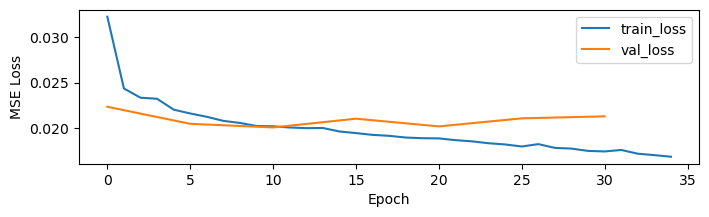

In [3]:
history = outputs['history']
plt.figure(figsize=(8, 2))
plt.plot(np.arange(len(history['loss'])), history['loss'], label='train_loss')
plt.plot( np.arange(0, len(history['loss']), config.val_interval), history['val_loss'], label='val_loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')

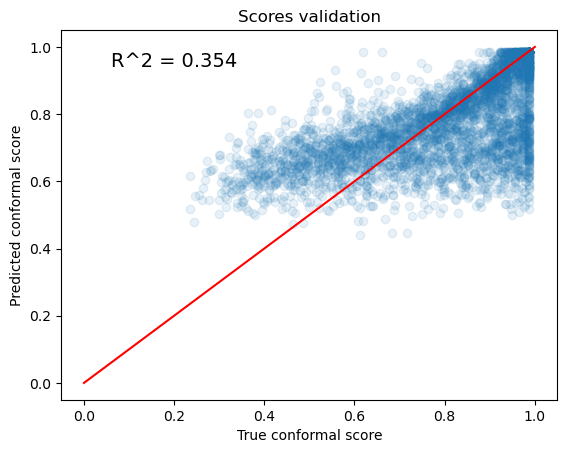

In [9]:
# outputs = val_outputs

def f(x):
    return x 
    # return np.minimum(x+0.112, 0.986)

o = outputs['test_out']
plt.scatter(o['true_scores'], f(o['pred_scores']), alpha = 0.1)
plt.plot([0,1], [0,1], color="red")
plt.xlabel("True conformal score")
plt.ylabel("Predicted conformal score")

r2 = utils.calc_r2(o['true_scores'], f(o['pred_scores']))

plt.text(0.1, 0.9, f"R^2 = {r2:.3f}", transform=plt.gca().transAxes, fontsize=14)
plt.title("Scores validation")
plt.show()

Text(0.5, 1.0, 'Conformal scores dists.')

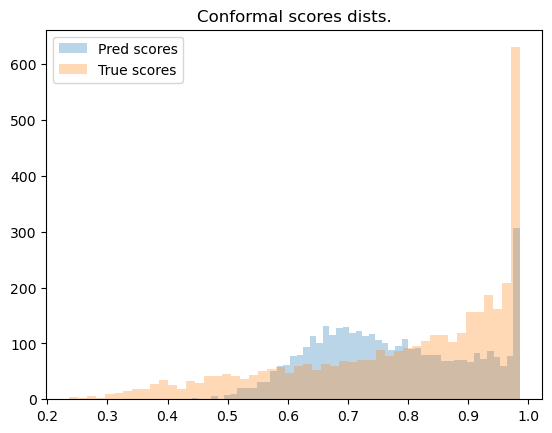

In [5]:
bins = 50
plt.hist(o['pred_scores'], bins, label='Pred scores', alpha=0.3)
plt.hist(o['true_scores'], bins, label='True scores', alpha=0.3)
plt.legend()
plt.title('Conformal scores dists.')

Text(0.5, 1.0, 'Diff')

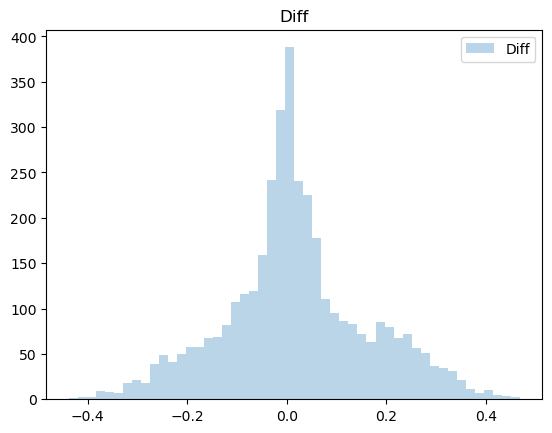

In [6]:
bins = 50
plt.hist(o['true_scores'] - o['pred_scores'], bins, label='Diff', alpha=0.3)
plt.legend()
plt.title('Diff')

In [7]:
# calibrate with the val set
pred_scores = outputs['val_out']['pred_scores']
true_scores = outputs['val_out']['true_scores']

diff = true_scores - pred_scores
alpha = config.alpha
n = len(diff)
qhat = np.quantile(
    diff, np.ceil((n + 1) * (1 - alpha)) / n, interpolation="higher")
print(qhat)

0.21286881


/tmp/ipykernel_216360/838491777.py:8: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  qhat = np.quantile(


In [8]:
from conformal import get_conformal_module, get_percentile, clip_scores, calibrate_residual
import copy

# calibrated_pred_scores = calibrate_residual(outputs['val_out']['true_scores'],
#                                             outputs['val_out']['pred_scores'], 
#                                             outputs['test_out']['true_scores'],
#                                             outputs['test_out']['pred_scores'], 
#                                             0.1)

calib_true_scores = outputs['train_out']['true_scores']
calib_pred_scores = outputs['train_out']['pred_scores'] 
valid_true_scores = outputs['test_out']['true_scores']
valid_pred_scores = outputs['test_out']['pred_scores']

# get the quantile from the residuals
diff = calib_true_scores - calib_pred_scores
n = len(diff)
qhat = np.quantile(
    diff, np.ceil((n + 1) * (1 - alpha)) / n, interpolation="higher")

# modify the validation scores
valid_pred_scores = copy.deepcopy(valid_pred_scores) + qhat
n_over_one = (valid_pred_scores >= 1.).sum() / len(valid_pred_scores)
print('Residuals correction is {:.3f}, clip {:.2f}% of the samples'.format(
    qhat, n_over_one * 100.))
calibrated_pred_scores = np.minimum(valid_pred_scores, (1 - alpha))


true_scores = outputs['test_out']['true_scores']
cls_probs = outputs['test_out']['cls_probs']
cls_labels = outputs['test_out']['cls_labels']

conformal_module = get_conformal_module(config.conformal_module_name)
sets = conformal_module.get_sets(calibrated_pred_scores, cls_probs)
mets = conformal_module.get_conformal_mets(sets, cls_labels)
print(mets)

Residuals correction is 0.192, clip 38.84% of the samples
{'size_mean': 2.393707033315706, 'size_std': 1.0493847795220652, 'acc': 0.9280803807509255}


/tmp/ipykernel_216360/3932674552.py:18: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  qhat = np.quantile(
